### Loss Error Experiments

The goal of these experiments is to understand the dependency of the original loss function in modelling the variance of the errors in the prediction. We try to validate the following hyphotesis:

### Hypothesis

> **H1**: Do we have the same result if we change the loss function from case a to case b?*
- a) - Original Exp.1 - 1 input tensor: (2dim: [y_hat, sigma]) and 1 loss error 
- b) - Common Usage* - 2 input tensors: [y_hat], [sigma] and 1 loss error (loss_yhat + loss_sigma)

*Validated with experiments: Experiment 0 (original - single loss error) | Experiment 1 (common usage - muli loss error)*

> * **H2**: What is the effect of each loss error (sigma and y) in updating the weights of the network?*

*Validated with experiments: Experiment 3 (multi loss error - different weights)*

> **H3**: What happens if we only propagate the y error while keeping updating the sigma on the fly?*

*Validated with experiment: Experiment 2 (single Loss Error - only y error)*

In [19]:
def weight_reset(m):
    if  isinstance(m, torch.nn.Linear):
        m.reset_parameters()

### Imports 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch.nn.functional as F

%matplotlib inline

### Generate some random data

In [2]:
# Generate some linearly related data
n_samples = 10000
x = np.random.random(n_samples)
eps = np.random.normal(scale=1.0, size=n_samples) * 0.4*np.sin(x*4*np.pi)
y = 2*x + 1 + eps

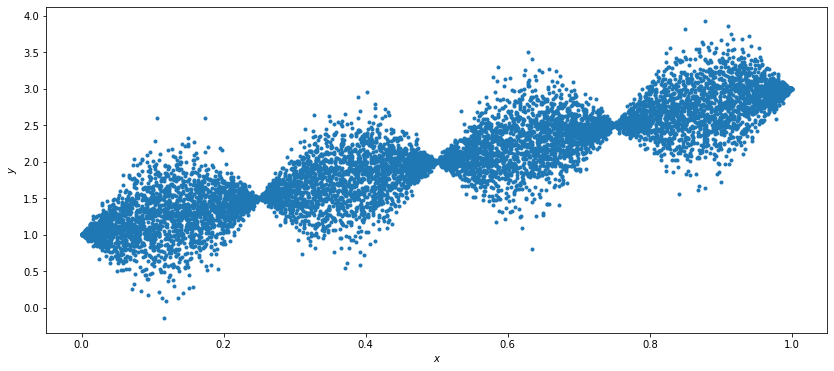

In [3]:
# Plot the data
plt.figure(figsize=(14,6))
plt.plot(x, y, '.')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

In [4]:
# Add in column of dummy zeros to represent the variance 
var = np.zeros(10000)
y = np.stack([y, var], axis=1)

In [5]:
# Reshape x for PyTorch
x = x.reshape(10000, 1)

In [6]:
# Split into training and validation sets
n_validation = 500
x_val, x = x[:n_validation], x[n_validation:]
y_val, y = y[:n_validation], y[n_validation:]

In [7]:
# Convert x and y to PyTorch Variables on the GPU
dtype = torch.cuda.FloatTensor
x = Variable(torch.from_numpy(x).type(dtype))
y = Variable(torch.from_numpy(y).type(dtype), requires_grad=False)

In [8]:
# Check shape ok for PyTorch - x should be (n x 1), y (n x 2)
x.shape, y.shape

(torch.Size([9500, 1]), torch.Size([9500, 2]))

### Create a simple network 

In [9]:
# Create a simple two-layer network with one input (x) and two outputs (y, sigma)
n_inputs = 1
n_outputs = 2
n_hidden = 1000
model = torch.nn.Sequential(torch.nn.Linear(n_inputs, n_hidden),
                            torch.nn.ReLU(),
                            torch.nn.Linear(n_hidden, n_outputs)
                           ).cuda()

In [10]:
# Adam optimizer
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Custom loss function
This is where the magic happens.

We compute separately the loss of the target and the variance   

In [11]:
def multi_loss_error(input, target):
    # Estimate target value for variance (sigma^2) with (y_pred - y)**2
    #
    #    actual y        is target[:,0]
    # predicted y        is input[:,0]
    #    actual variance is target[:,1] - estimated here
    # predicted variance is input[:,0]
    
    # Use 'requires_grad == False' to prevent PyTorch from trying to differentiate 'target'
    target[:,1] = Variable((input[:,0].data - target[:,0].data)**2, 
                           requires_grad=False)  # compute variance
    # Return MSE loss 
    return F.mse_loss(input[:,1], target[:,1]), F.mse_loss(input[:,0], target[:,0])

We jointly compute the loss of the target and variance. We return a single scalar

In [12]:
def single_loss_error(input, target):
    # Estimate target value for variance (sigma^2) with (y_pred - y)**2
    #
    #    actual y        is target[:,0]
    # predicted y        is input[:,0]
    #    actual variance is target[:,1] - estimated here
    # predicted variance is input[:,0]
    
    # Use 'requires_grad == False' to prevent PyTorch from trying to differentiate 'target'
    target[:,1] = Variable((input[:,0].data - target[:,0].data)**2, 
                           requires_grad=False)  # compute variance
    # Return MSE loss 
    return F.mse_loss(input, target)

We only compute the loss of the target

In [13]:
def single_loss_y_error(input, target):
    # Estimate target value for variance (sigma^2) with (y_pred - y)**2
    #
    #    actual y        is target[:,0]
    # predicted y        is input[:,0]
    #    actual variance is target[:,1] - estimated here
    # predicted variance is input[:,0]
    
    # Use 'requires_grad == False' to prevent PyTorch from trying to differentiate 'target'
    target[:,1] = Variable((input[:,0].data - target[:,0].data)**2, 
                           requires_grad=False)  # compute variance
    # Return MSE loss 
    return F.mse_loss(input[:,0], target[:,0])

## Experiments

> **H1**: Do we have the same result if we change the loss function from case a to case b?*
- a) - Original Exp.1 - 1 input tensor: (2dim: [y_hat, sigma]) and 1 loss error 
- b) - Common Usage* - 2 input tensors: [y_hat], [sigma] and 1 loss error (loss_yhat + loss_sigma)

*Validated with experiments: Experiment 0 (original - single loss error) | Experiment 1 (common usage - muli loss error)*

*We try to validate the case b) as it is found more frequently in most of implementations 

### Experiment 0 - Single Loss Error - Original

This is the original implementation of the technique

In [14]:
# We reset model weights and sigma variance
        
model.apply(weight_reset)

y[:,1] = torch.zeros(y.shape[0]).cuda() # reset sigma

#### Training loop 
We train this simple model with batch size equal to the whole dataset.

In [15]:
n_epochs = 10000
for i in range(n_epochs):
    
    # Calculate predicted y from x
    y_pred = model(x)
    
    # Calculate loss
    loss = single_loss_error(y_pred, y)
    if i%500 == 0: print(f'epoch: {i:4}, loss: {loss.data.item():.3}',)

    # Backprop, first zeroing gradients
    optimizer.zero_grad()
    loss.backward()

    # Update parameters
    optimizer.step()

epoch:    0, loss: 9.65
epoch:  500, loss: 0.0513
epoch: 1000, loss: 0.051
epoch: 1500, loss: 0.0508
epoch: 2000, loss: 0.0507
epoch: 2500, loss: 0.0505
epoch: 3000, loss: 0.0504
epoch: 3500, loss: 0.0503
epoch: 4000, loss: 0.0502
epoch: 4500, loss: 0.0501
epoch: 5000, loss: 0.05
epoch: 5500, loss: 0.05
epoch: 6000, loss: 0.0502
epoch: 6500, loss: 0.05
epoch: 7000, loss: 0.0502
epoch: 7500, loss: 0.0502
epoch: 8000, loss: 0.05
epoch: 8500, loss: 0.05
epoch: 9000, loss: 0.05
epoch: 9500, loss: 0.05


#### Results

In [16]:
# Get predicted y and its predicted variance for validation set
x_val_pytorch = Variable(torch.from_numpy(x_val).type(dtype)) 
pred = model(x_val_pytorch)
y_pred = pred[:,0].cpu().data
variance_pred = pred[:,1].cpu().data

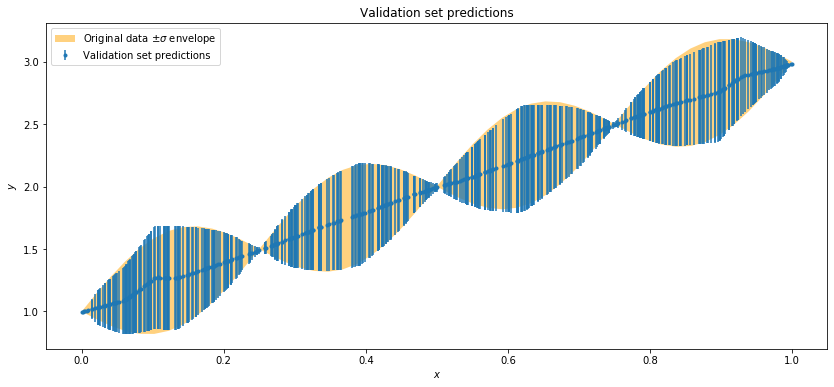

In [17]:
# Plot predictions and their errors
plt.figure(figsize=(14,6))
plt.errorbar(x_val, y_pred, yerr=variance_pred.sqrt() , fmt='.'); 

# One standard-deviation envelope
xs = np.linspace(0.0, 1.0, 50)
err = 0.4*np.sin(xs*4*np.pi)
plt.fill_between(xs, 2*xs+1-err, 2*xs+1+err, facecolor='orange', alpha=0.5, edgecolor='none');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.title('Validation set predictions');
plt.legend([r'Original data $\pm \sigma$ envelope','Validation set predictions'], loc='upper left', );

### Experiment 1 - Multi Loss Error  - Same Weights

Here, we compute the loss error separetly and return two scalars, one for each. **The goal is to ensure compability of Tensorflow and Pytorch frameworks**:

 "....except that the losses have to be computed for both outputs and added together before performing backpropagation and model weight updates.." [1]

For the implemenation of this method has been taken as a reference:

[1] https://towardsdatascience.com/converting-a-deep-learning-model-with-multiple-outputs-from-pytorch-to-tensorflow-a2d27a8e44f4

In [18]:
model.apply(weight_reset)
y[:,1] = torch.zeros(y.shape[0]).cuda() # reset sigma

#### Training loop 
We train this simple model with batch size equal to the whole dataset.

In [20]:
n_epochs = 10000
for i in range(n_epochs):
    
    # Calculate predicted y from x
    y_pred = model(x)
    
    # Calculate loss
    loss_var, loss_y = multi_loss_error(y_pred, y)
    if i%500 == 0: print(f'epoch: {i:4}, loss: {loss_y.data.item():.3}',)

    # Backprop, first zeroing gradients
    optimizer.zero_grad()
    loss = torch.add(loss_var, loss_y)
    loss.backward()

    # Update parameters
    optimizer.step()

epoch:    0, loss: 5.25
epoch:  500, loss: 0.0805
epoch: 1000, loss: 0.0805
epoch: 1500, loss: 0.0805
epoch: 2000, loss: 0.0805
epoch: 2500, loss: 0.0805
epoch: 3000, loss: 0.0805
epoch: 3500, loss: 0.0805
epoch: 4000, loss: 0.0804
epoch: 4500, loss: 0.0804
epoch: 5000, loss: 0.0804
epoch: 5500, loss: 0.0804
epoch: 6000, loss: 0.0804
epoch: 6500, loss: 0.0804
epoch: 7000, loss: 0.0804
epoch: 7500, loss: 0.0805
epoch: 8000, loss: 0.0804
epoch: 8500, loss: 0.0804
epoch: 9000, loss: 0.0804
epoch: 9500, loss: 0.0803


#### Results

In [21]:
# Get predicted y and its predicted variance for validation set
x_val_pytorch = Variable(torch.from_numpy(x_val).type(dtype)) 
pred = model(x_val_pytorch)
y_pred = pred[:,0].cpu().data
variance_pred = pred[:,1].cpu().data

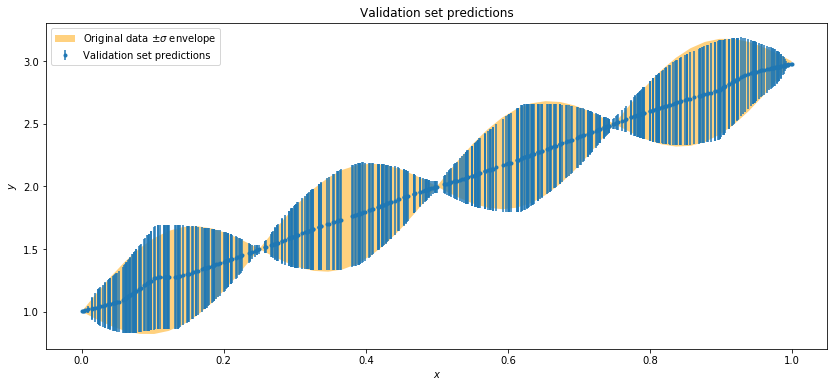

In [22]:
# Plot predictions and their errors
plt.figure(figsize=(14,6))
plt.errorbar(x_val, y_pred, yerr=variance_pred.sqrt() , fmt='.'); 

# One standard-deviation envelope
xs = np.linspace(0.0, 1.0, 50)
err = 0.4*np.sin(xs*4*np.pi)
plt.fill_between(xs, 2*xs+1-err, 2*xs+1+err, facecolor='orange', alpha=0.5, edgecolor='none');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.title('Validation set predictions');
plt.legend([r'Original data $\pm \sigma$ envelope','Validation set predictions'], loc='upper left', );

#### Conclusions

We get exactly the same results. The Pytorch loss function implementation does this underneath*.
The loss 'multi_loss_error' is the recommended and common implementation for working with multi output tensors 

*La función de MSE de Pytorch hace un reduce_mean de ambas dimensiones para quedarse con un error escalar que es el que usará en backpropagation

### Experiment 2 - Single Loss Error - Only y error 

> **H3**: What happens if we only propagate the y error while keeping updating the sigma on the fly?*

*Validated with experiment: Experiment 2 (single Loss Error - only y error)*

In [23]:
def weight_reset(m):
    if  isinstance(m, torch.nn.Linear):
        m.reset_parameters()

        
model.apply(weight_reset)

y[:,1] = torch.zeros(y.shape[0]).cuda() # reset sigma

In [24]:
w_sigma = 0.4
w_y = 0.6

In [25]:
n_epochs = 10000
for i in range(n_epochs):
    
    # Calculate predicted y from x
    y_pred = model(x)
    
    # Calculate loss
    loss_y = single_loss_y_error(y_pred, y)
    if i%500 == 0: print(f'epoch: {i:4}, loss: {loss_y.data.item():.3}',)

    # Backprop, first zeroing gradients
    optimizer.zero_grad()
    loss = loss_y
    
    loss.backward()

    # Update parameters
    optimizer.step()

epoch:    0, loss: 5.01
epoch:  500, loss: 0.0805
epoch: 1000, loss: 0.0805
epoch: 1500, loss: 0.0805
epoch: 2000, loss: 0.0805
epoch: 2500, loss: 0.0804
epoch: 3000, loss: 0.0804
epoch: 3500, loss: 0.0804
epoch: 4000, loss: 0.0804
epoch: 4500, loss: 0.0804
epoch: 5000, loss: 0.0804
epoch: 5500, loss: 0.0804
epoch: 6000, loss: 0.0804
epoch: 6500, loss: 0.0804
epoch: 7000, loss: 0.0804
epoch: 7500, loss: 0.0804
epoch: 8000, loss: 0.0804
epoch: 8500, loss: 0.0804
epoch: 9000, loss: 0.0803
epoch: 9500, loss: 0.0803


In [26]:
# Get predicted y and its predicted variance for validation set
x_val_pytorch = Variable(torch.from_numpy(x_val).type(dtype)) 
pred = model(x_val_pytorch)
y_pred = pred[:,0].cpu().data
variance_pred = pred[:,1].cpu().data

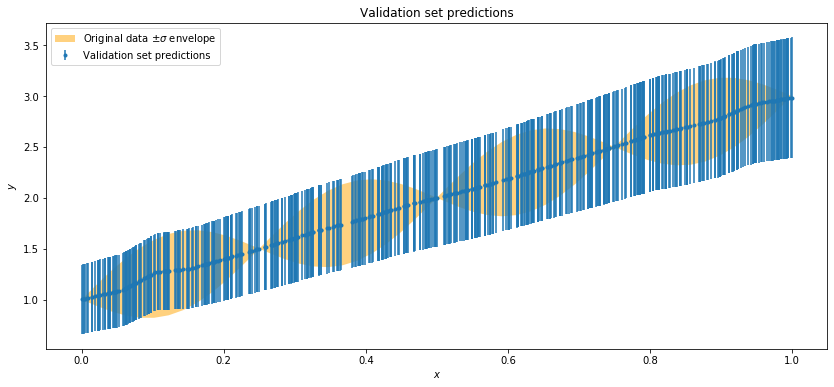

In [27]:
# Plot predictions and their errors
plt.figure(figsize=(14,6))
plt.errorbar(x_val, y_pred, yerr=variance_pred.sqrt(), fmt='.'); 

# One standard-deviation envelope
xs = np.linspace(0.0, 1.0, 50)
err = 0.4*np.sin(xs*4*np.pi)
plt.fill_between(xs, 2*xs+1-err, 2*xs+1+err, facecolor='orange', alpha=0.5, edgecolor='none');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.title('Validation set predictions');
plt.legend([r'Original data $\pm \sigma$ envelope','Validation set predictions'], loc='upper left', );

#### Conclusions

We get an homoscedastic variance

### Experiment 3 - Multi Loss Error - Different Weights - w_sigma, w_y

> * **H2**: What is the effect of each loss error (sigma and y) in updating the weights of the network?*

*Validated with experiments: Experiment 3 (multi loss error - different weights)*

In [28]:
model.apply(weight_reset)

y[:,1] = torch.zeros(y.shape[0]).cuda() # reset sigma

In [29]:
w_sigma = 0.005
w_y = 1

In [30]:
n_epochs = 10000
for i in range(n_epochs):
    
    # Calculate predicted y from x
    y_pred = model(x)
    
    # Calculate loss
    loss_var, loss_y = multi_loss_error(y_pred, y)
    if i%500 == 0: print(f'epoch: {i:4}, loss: {loss_y.data.item():.3}',)

    # Backprop, first zeroing gradients
    optimizer.zero_grad()
    loss = torch.add(loss_var * w_sigma, loss_y * w_y)
    loss = loss 
    
    loss.backward()

    # Update parameters
    optimizer.step()

epoch:    0, loss: 3.9
epoch:  500, loss: 0.0805
epoch: 1000, loss: 0.0805
epoch: 1500, loss: 0.0805
epoch: 2000, loss: 0.0805
epoch: 2500, loss: 0.0804
epoch: 3000, loss: 0.0804
epoch: 3500, loss: 0.0804
epoch: 4000, loss: 0.0804
epoch: 4500, loss: 0.0804
epoch: 5000, loss: 0.0804
epoch: 5500, loss: 0.0804
epoch: 6000, loss: 0.0807
epoch: 6500, loss: 0.0804
epoch: 7000, loss: 0.0804
epoch: 7500, loss: 0.0804
epoch: 8000, loss: 0.0803
epoch: 8500, loss: 0.0803
epoch: 9000, loss: 0.0807
epoch: 9500, loss: 0.0803


In [31]:
# Get predicted y and its predicted variance for validation set
x_val_pytorch = Variable(torch.from_numpy(x_val).type(dtype)) 
pred = model(x_val_pytorch)
y_pred = pred[:,0].cpu().data
variance_pred = pred[:,1].cpu().data

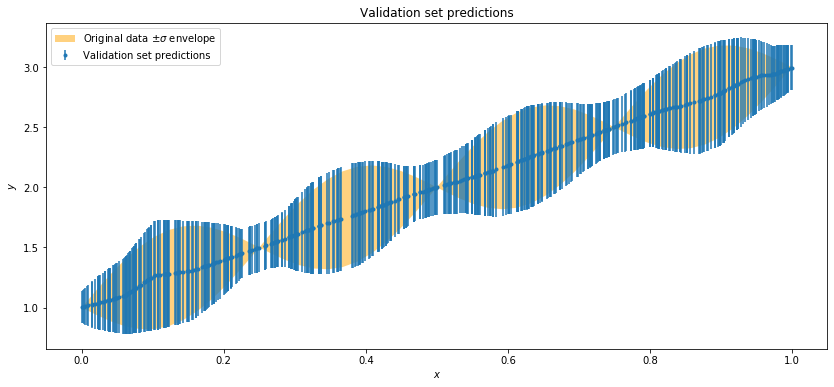

In [32]:
# Plot predictions and their errors
plt.figure(figsize=(14,6))
plt.errorbar(x_val, y_pred, yerr=variance_pred.sqrt() , fmt='.'); 

# One standard-deviation envelope
xs = np.linspace(0.0, 1.0, 50)
err = 0.4*np.sin(xs*4*np.pi)
plt.fill_between(xs, 2*xs+1-err, 2*xs+1+err, facecolor='orange', alpha=0.5, edgecolor='none');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.title('Validation set predictions');
plt.legend([r'Original data $\pm \sigma$ envelope','Validation set predictions'], loc='upper left', );

#### Conclusions

We see that the y loss dominates the training. We only need to propagate a small portion of the variance loss to get almost the same effect. This is due to the dependency of the loss variance and the loss of the tar

### Conclusions

- We have found a most appropiate method to compute the loss. This method is compatible with Tensorflow. We can export it with ONNX (Future steps)
- It is required to update the loss variance at every step of the training process
- The y loss dominates the training. We only need to propagate a small portion of the variance loss

### Future Steps

Here, we observe that the correlation between the y and variance loss remains more or less constant over time (the target is a linear function). Thus, the uncertainty is correlated over time.

- We may try with a different dataset that exposes different patterns or generation processes over time